### Phys 629, Fall 2023, University of Mississippi


# Lecture 22, Chapter 5: Bayesian Statistical Inference

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.
- [MCMC Sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling) by Thomas Wiecki.
- [Sampler, Samplers, Everywhere...](http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/) by Matt Pitkin.
- [MCMC Interactive Demo](https://chi-feng.github.io/mcmc-demo/app.html) by Chi Feng.

***Exercises required for class participation are in <font color='red'>red</font>.***

***BEFORE YOU START:*** Please pause for a few minutes and install these package `dynesty` before going through today's notebook. Make sure this notebook is in the correct Python kernel for the class conda environment before executing each of the following cells in turn. *(The second package you'll install below is just cython, which wraps C code in Python structures.)*

In [1]:
# !pip3 install dynesty

In [2]:
# !pip3 install cython

In [3]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')

##  MCMC Parameter Estimation In The Wild <a class="anchor" id="two"></a>

Let's look at some more involved examples. We will use two popular python modules: `emcee` and `PyMC`.  `PTMCMCSampler` is a less used sampler that is the standard one used in gravitational-wave astrophysics. Quoting Jake VanderPlas for `emcee` and `PyMC`: 
[Jake's blog:](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

### emcee

> The emcee package (*also known as MCMC Hammer, which is in the running for best Python package name in history*) is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".

Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

### PyMC

> The PyMC package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries, so it is less trivial to install using tools like pip. PyMC binaries for many systems can be quite easily installed with conda.*

More details about PyMC are available from [the pyMC User Guide](https://pymc-devs.github.io/pymc/), but note that we are going to be using [PyMC3](https://docs.pymc.io/).

### PTMCMCSampler

> This is a bare-bones sampler, requiring only that the user provide a log-likelihood function and a log-prior function. The user can change the relative amounts of AM, SCAM, and DE being used to propose new points to jump to. The great thing about this sampler is that one can add new custom proposal schemes according to the user's preference. 

> Also, this sampler implements **parallel tempering MCMC (PTMCMC)**. We won't go into detail about this, but suffice it to say that multiple copies of the MCMC are run in parallel, where the copies actually sample from different roots of the likelihood. The higher roots we take, the more the likelihood is flattened out, making it easier to sample. These "rooted" chains then communicate back to the main chain, improving exploration of the parameter space. All these chains can actually be post-processed to get the Bayesian evidence too, in a scheme called **thermodynamic integration**.

##  MCMC with emcee <a class="anchor" id="three"></a>

Import `emcee` and generate some homoescedastic Gaussian data. We'll assume the standard deviation is known, so we're only estimating $\mu$.

In [4]:
import emcee
import numpy as np
import scipy.stats

np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = scipy.stats.norm(mu, sigma).rvs(Ndata)

Define all the relevant functions.

In [5]:
def Likelihood(x, sigma, data):
    # Gaussian likelihood 
    return np.prod(np.exp(-(data-x)**2 /2 /sigma**2))

def Prior(x):
    return 1.0 / 10   # flat: it cancels out and has no effect 

def myPosterior(x, sigma, data):
    return Likelihood(x, sigma, data) * Prior(x)

# emcee wants ln of posterior pdf
def myLogPosterior(x, sigma, data):
    return np.log(myPosterior(x, sigma, data))

`emcee` combines multiple "walkers", each of which is its own MCMC chain. The number of trace results will be nwalkers $\times$ nsteps.

In [9]:
ndim = 1  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[sigma, data])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

done


In [10]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain

(6, 5000, 1)
(24000, 1)


Text(0.5, 1.0, 'Chain from emcee')

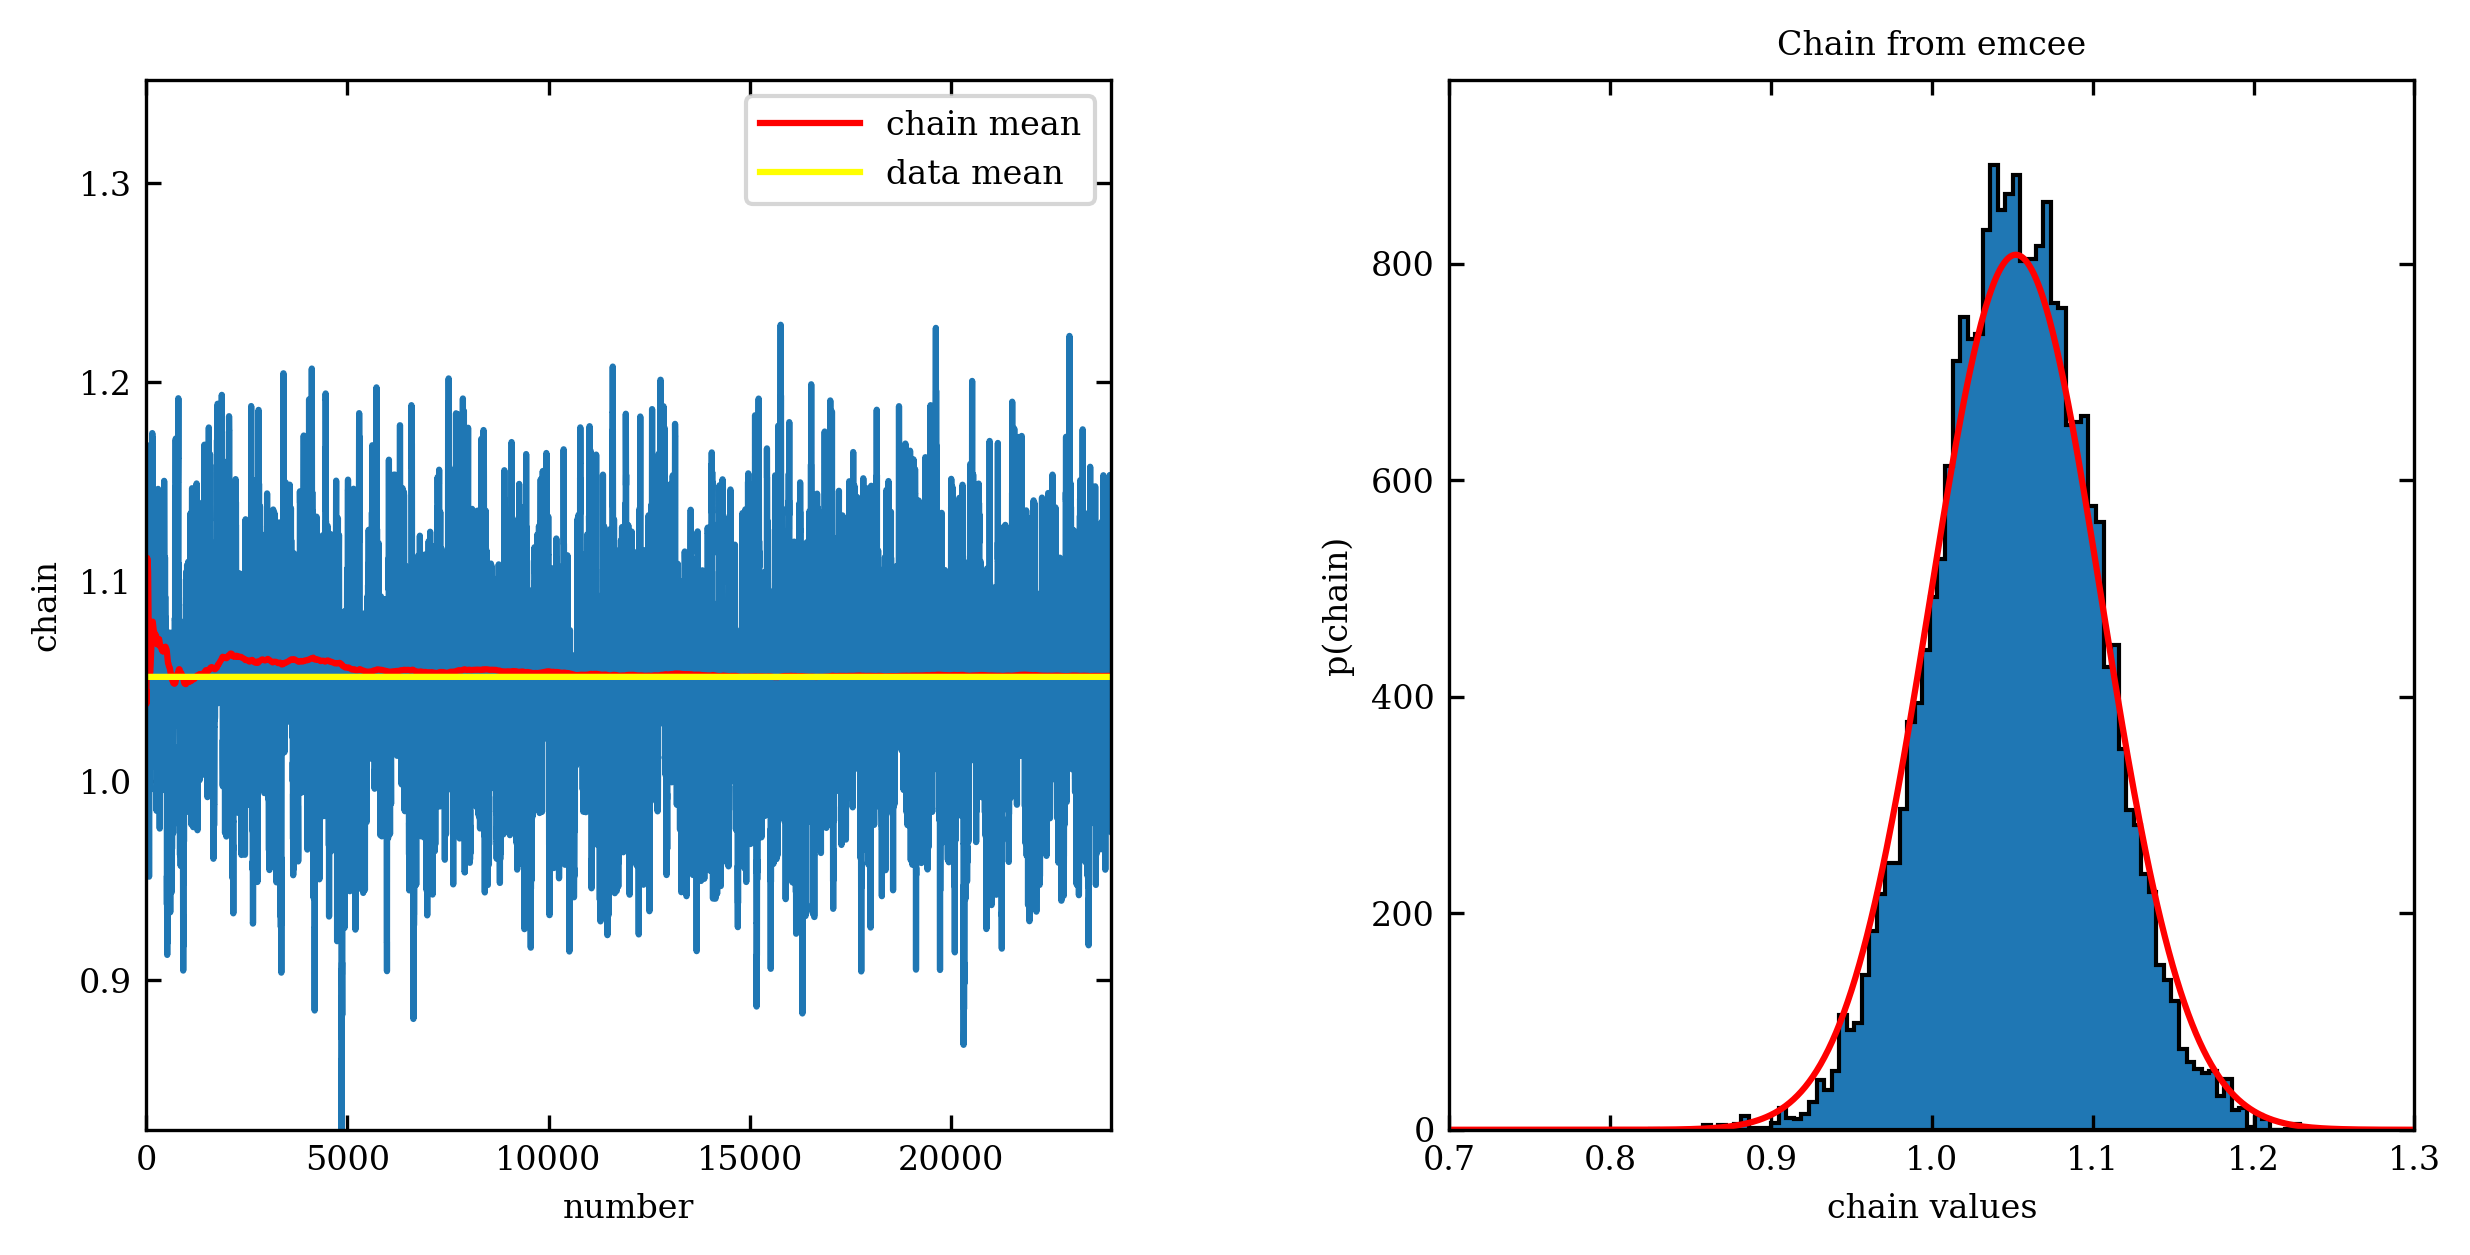

In [24]:
# plot
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, 
                    wspace=0.35, bottom=0.18)

chainE = emcee_trace #[0]
M = np.size(chainE)

ax1 = fig.add_subplot(121)
xgrid = np.linspace(1, M, M)
plt.plot(xgrid, chainE)
ax1.axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
plt.xlabel('number')
plt.ylabel('chain')

# plot running mean: 
meanC = [np.mean(chainE[:int(N)]) for N in xgrid]
ax1.plot(xgrid, meanC, c='red', label='chain mean') 
ax1.plot(xgrid, 0*xgrid + np.mean(data),
         c='yellow',label='data mean')
ax1.legend()

ax2 = fig.add_subplot(122)
# skip first burn samples
burn = 1000
Nchain = np.size(chainE[xgrid>burn])
Nhist, bins, patches = plt.hist(chainE[xgrid>burn], 
                                bins='auto', histtype='stepfilled')

# plot expectations based on central limit theorem
binwidth = bins[1] - bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = Nchain * binwidth * scipy.stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 

ax2.set_ylabel('p(chain)')
ax2.set_xlabel('chain values')
ax2.set_xlim(0.7, 1.3)
ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title('Chain from emcee')

##  MCMC with PyMC3 <a class="anchor" id="four"></a>

Now we will use pyMC3 to get a 2-dimensional posterior pdf for location and scale parameters using a sample drawn from a **Cauchy distribution**. Remember a Cauchy distribution formally has no mean or standard deviation because its tails fall off shallower than $1/x^2$.

The following is code adapted from Figure 5.22 of the textbook. Initially, we load in `PyMC3` and define the Cauchy log likelihood. 

***NOTE:*** The code here for the Cauchy likelihood is actually only for when we look at the analytic estimate, since `PyMC3` has ready-made modules for many standard functions!

In [13]:
from scipy.stats import cauchy
import pymc3 as pm

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))

Generate some data from the Cauchy distribution.

In [14]:
# ----------------------------------------------------------------------
# Draw the sample from a Cauchy distribution
import numpy as np
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

Set up the `PyMC3` model.

In [15]:
# ----------------------------------------------------------------------
# Set up and run MCMC:
with pm.Model():
    mu = pm.Uniform('mu', -5, 5) #uniform in Cauchy mu
    log_gamma = pm.Uniform('log_gamma', -10, 10) #uniform in log of Cauchy gamma

    # set up our observed variable x
    # i.e. read this as 'x is distributed as a Cauchy variable'
    x = pm.Cauchy('x', mu, np.exp(log_gamma), observed=xi)

    trace = pm.sample(draws=12000, tune=1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_gamma, mu]


Sampling 2 chains for 1_000 tune and 12_000 draw iterations (2_000 + 24_000 draws total) took 9 seconds.


You may have seen some output messages along the lines of "Auto-assigning NUTS sampler...". `PyMC3` is very sophisticated, and will automatically decide for you the best tools for the job. 

In this case, it decided you needed **No-U-Turn Hamiltonian gradient-based sampling**, where gradient information about the Cauchy likelihood helped in the exploration of parameter space. 

In [16]:
# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace['mu'],
                                             np.exp(trace['log_gamma']),
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

# ----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(trace['mu'], bins=mu_bins, density=True)
hist_gamma, bins_gamma = np.histogram(np.exp(trace['log_gamma']),
                                      bins=gamma_bins, density=True)

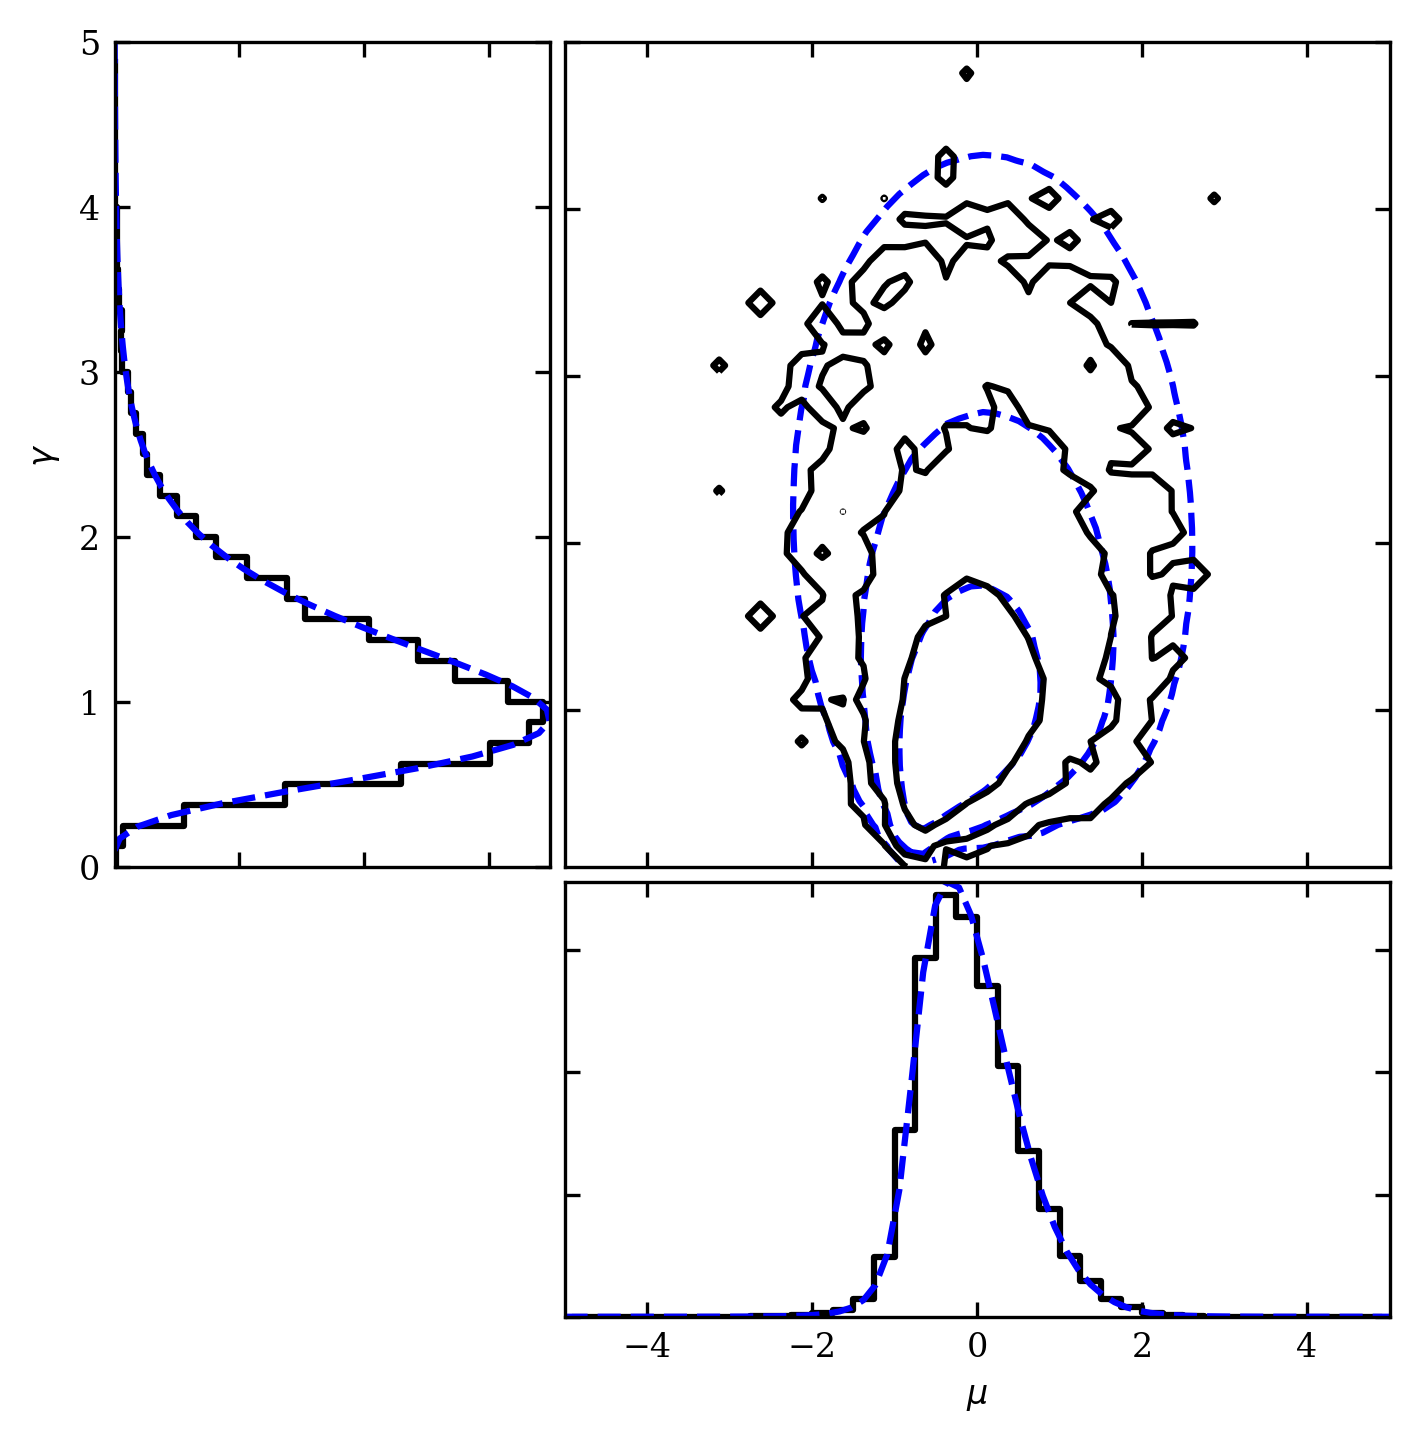

In [17]:
# ----------------------------------------------------------------------
# plot all the results
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

The resulting $2$D joint posterior pdf corner plot shows analytic results as blue dashed lines, and MCMC sampling results as black contours.

## MCMC With The PTMCMCSampler <a class="anchor" id="five"></a>

Let's now explore the more bare-bones sampler. This helps to expose a lot of what is going on in the other samplers, where it's difficult to see what happens under the hood.

**We're going to analyze a homoescedastic Gaussian dataset, but this time search over the mean and standard deviation with our MCMC.**

In [18]:
# don't worry about any warning messages regarding mpi4py
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Optional mpi4py package is not installed.  MPI support is not available.


In [19]:
np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

Fill in the function below to create a prior function that is the multiplication of a uniform prior for the mean over $0.5$ to $1.5$, and a uniform prior for the standard deviation between $0.1$ and $0.9$. 

The priors are separable and independent, so the overall prior should be the product of the prior for each parameter.

In [20]:
def Likelihood(x, data):
    # Gaussian likelihood 
    return np.prod(stats.norm(loc=x[0], scale=x[1]).pdf(data))

def Prior(x):
    # create a uniform prior in mu and sigma
    return (1/(1.5-0.5))*(1/(0.9-0.1))

def logLikelihood(x):
    return np.log(Likelihood(x, data))

def logPrior(x):
    return np.log(Prior(x))

In [21]:
# dimension of parameter space
ndim = 2

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler = ptmcmc(ndim, logLikelihood, logPrior, cov, 
                 outDir='./my_ptmcmc_chain', resume=False)

Start sampling!

In [22]:
# sampler for N steps
N = int(2e4)
x0 = np.array([0.9, 0.3])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 50.00 percent in 4.353028 s Acceptance rate = 0.550989Adding DE jump with weight 50
Finished 95.00 percent in 8.129784 s Acceptance rate = 0.614895
Run Complete


In [64]:
# Load in the chain using pandas

import pandas as pd


chain = pd.read_csv('./my_ptmcmc_chain/chain_1.txt', delimiter = '\t')

#Renaming columns (first one is mu_chain and second one is sigma_chain)
new_columns = {
    0: 'mu',
    1: 'sigma',
    2: 'a',
    3: 'b',
    4: 'c',
    5: 'd'
}

chain = chain.rename(columns=new_columns)

# Set the column names explicitly
chain.columns = new_columns.values()

In [65]:
chain

,mu,sigma,a,b,c,d
0,0.913051,0.317402,-127.553577,-127.776721,0.841000,1.0
1,0.932128,0.362935,-103.654407,-103.877551,0.841000,1.0
2,0.950134,0.395487,-93.075674,-93.298818,0.841000,1.0
3,0.984387,0.449412,-83.174414,-83.397558,0.841000,1.0
4,0.985437,0.508489,-79.851824,-80.074968,0.841000,1.0
...,...,...,...,...,...,...
1894,1.099140,0.589378,-80.020891,-80.244034,0.614895,1.0
1895,1.059122,0.538797,-78.779228,-79.002372,0.614895,1.0
1896,1.094163,0.521051,-79.136548,-79.359691,0.614895,1.0
1897,1.020835,0.492861,-79.610663,-79.833807,0.614895,1.0


Ignore the final 4 columns in your chain array. Those are chain diagnostics, not parameters.

<font color='red'>OK, now that you have your chain, it's up to you to diagnose it.</font>
    
- <font color='red'>Make traceplots in both $\mu$ and $\sigma$.</font>
- <font color='red'>Discuss when you should cut off burn-in.</font>
- <font color='red'>Compute the autocorrelation length of the chain, and down-sample it to select only points every autocorrelation length.</font>
- <font color='red'>Finally, make a corner plot that has labels, shows titles, and has $68\%$ and $95\%$ quantiles and levels.</font>

In [55]:
#plot the traceplots for both mu and sigma

# a = np.array([1,2,3.4,5,6,7])
# a = a[::2] # delete every second element from the array
# print(a)

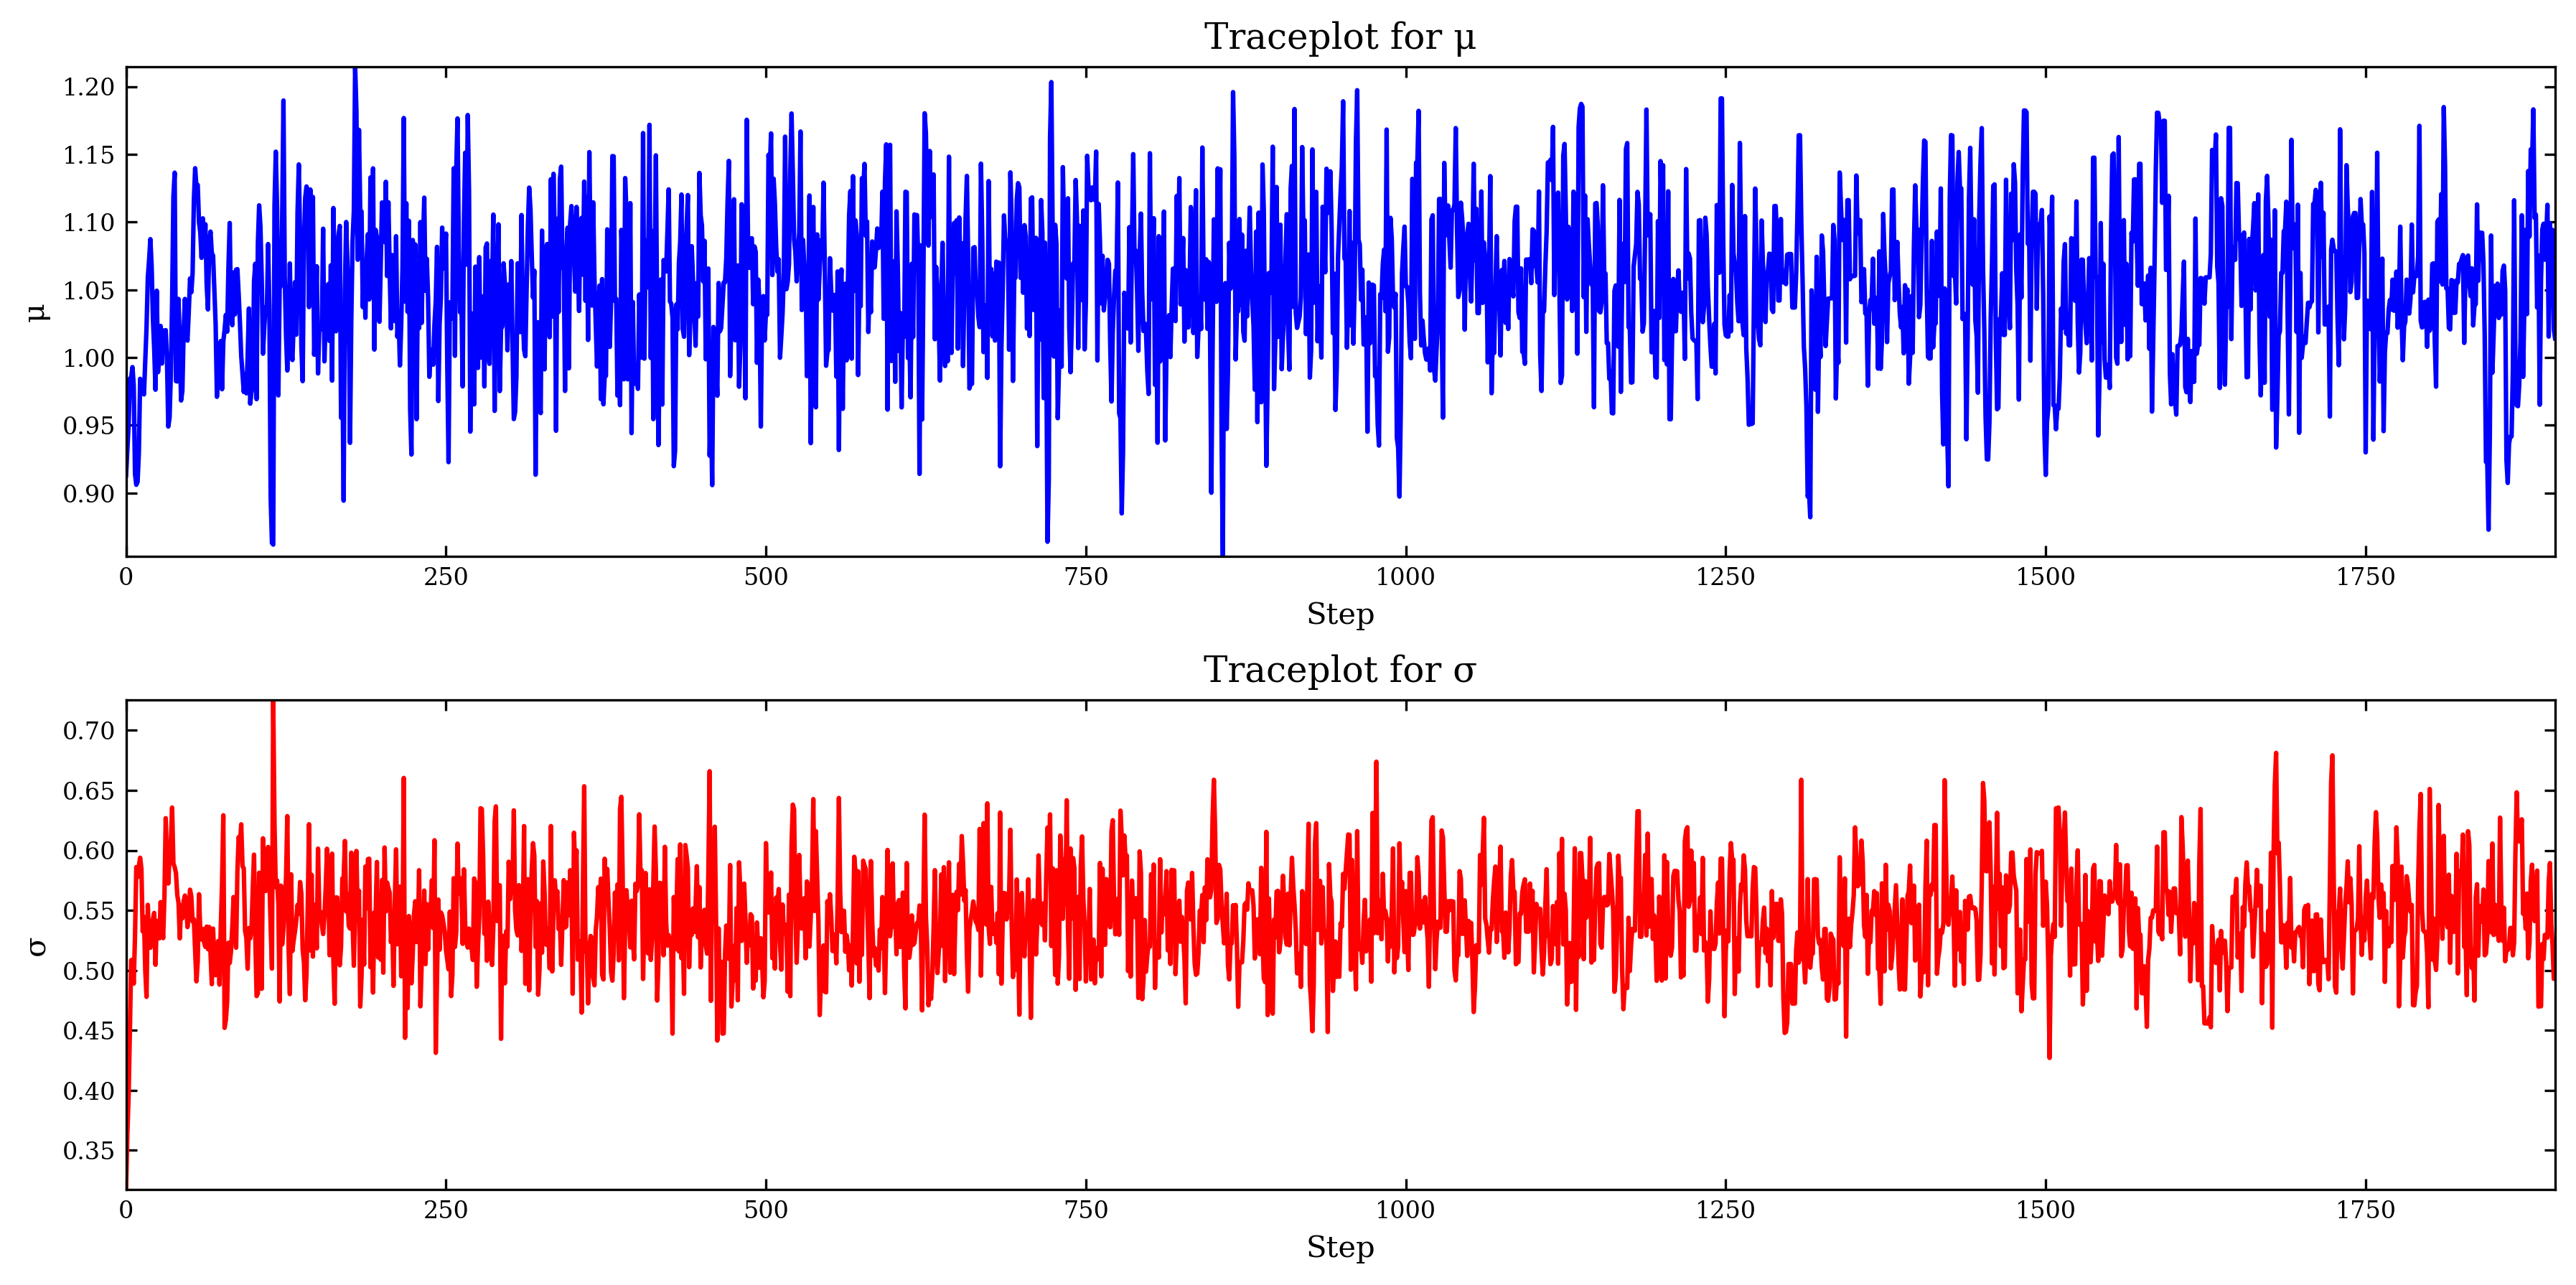

In [45]:
#Traceplots

import matplotlib.pyplot as plt

# Traceplots
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(chain['mu'], 'b-')
plt.xlabel('Step',fontsize = 10)
plt.ylabel('μ',fontsize = 10)
plt.title('Traceplot for μ',fontsize = 12)

plt.subplot(2, 1, 2)
plt.plot(chain['sigma'], 'r-')
plt.xlabel('Step',fontsize = 10)
plt.ylabel('σ',fontsize = 10)
plt.title('Traceplot for σ',fontsize = 12)

plt.tight_layout()
plt.show()


In [66]:
#Then decide what is the burn in phase

#Let us decide the burn-in to be 550
burn = 550

#Updating the chains
chain['mu'] = chain['mu'][burn:]
chain['sigma'] = chain['sigma'][burn:]





In [87]:
chain['mu'].values, chain['mu'][burn:].values

(array([       nan,        nan,        nan, ..., 1.09416298, 1.02083496,
        1.01417206]),
 array([1.07329255, 1.04867668, 1.03467235, ..., 1.09416298, 1.02083496,
        1.01417206]))

In [68]:
#Computing the Autocorrelation length


import acor

mu_chain = chain['mu'][burn:].values  # Extract the 'mu_chain' column as a NumPy array
autocorrelation_length = acor.acor(mu_chain)[0]

print("Autocorrelation Length for 'mu_chain':", autocorrelation_length)


Autocorrelation Length for 'mu_chain': 2.2254106232315207


In [70]:
#Computing the Autocorrelation length for sigma chain


import acor

sigma_chain = chain['sigma'][burn:].values  # Extract the 'mu_chain' column as a NumPy array
autocorrelation_length = acor.acor(sigma_chain)[0]

print("Autocorrelation Length for 'sigma_chain':", autocorrelation_length)


Autocorrelation Length for 'sigma_chain': 1.9767586685244771


Thus we can remove every second sample to downsample it (since the ACR length is close to 2 for both $\mu$ and $\sigma$

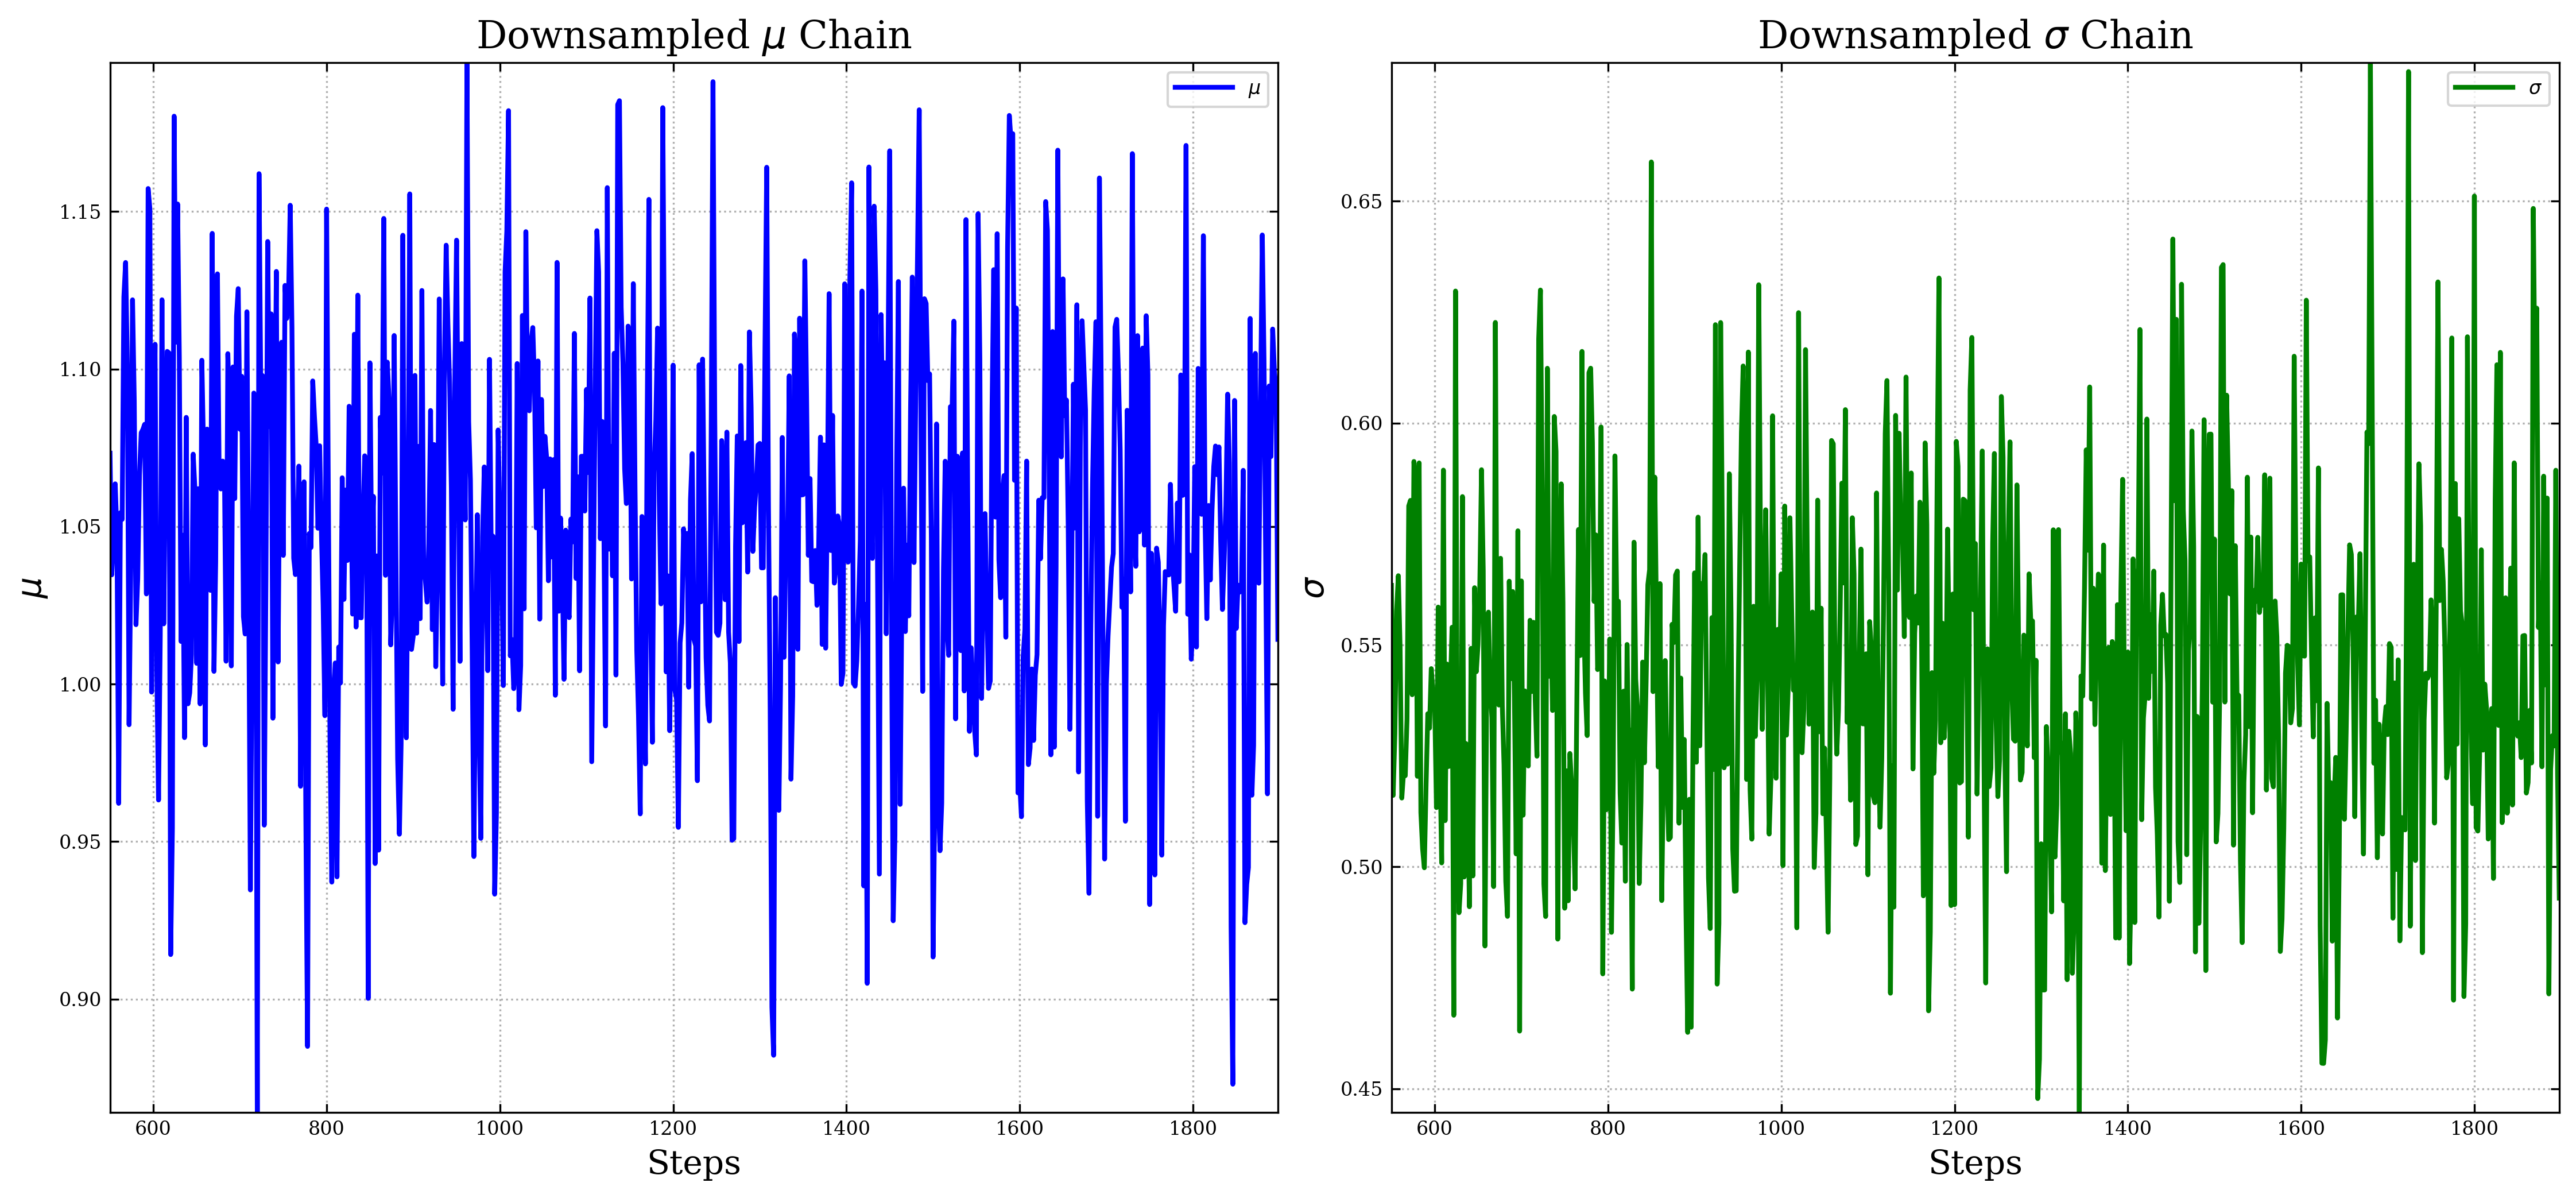

In [71]:
import matplotlib.pyplot as plt

# Do downsampling
mu_downsampled = chain['mu'][::2]
sigma_downsampled = chain['sigma'][::2]

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 7)

# Plot for mu_downsampled
ax[0].plot(mu_downsampled, color='blue', linestyle='-', linewidth=2, label='$\mu$')
ax[0].set_xlabel('Steps', fontsize = 14)
ax[0].set_ylabel('$\mu$', fontsize = 14)
ax[0].set_title('Downsampled $\mu$ Chain', fontsize = 16)
ax[0].grid(True)
ax[0].legend()

# Plot for sigma_downsampled
ax[1].plot(sigma_downsampled, color='green', linestyle='-', linewidth=2, label='$\sigma$')
ax[1].set_xlabel('Steps', fontsize = 14)
ax[1].set_ylabel('$\sigma$', fontsize = 14)
ax[1].set_title('Downsampled $\sigma$ Chain', fontsize = 16)
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()


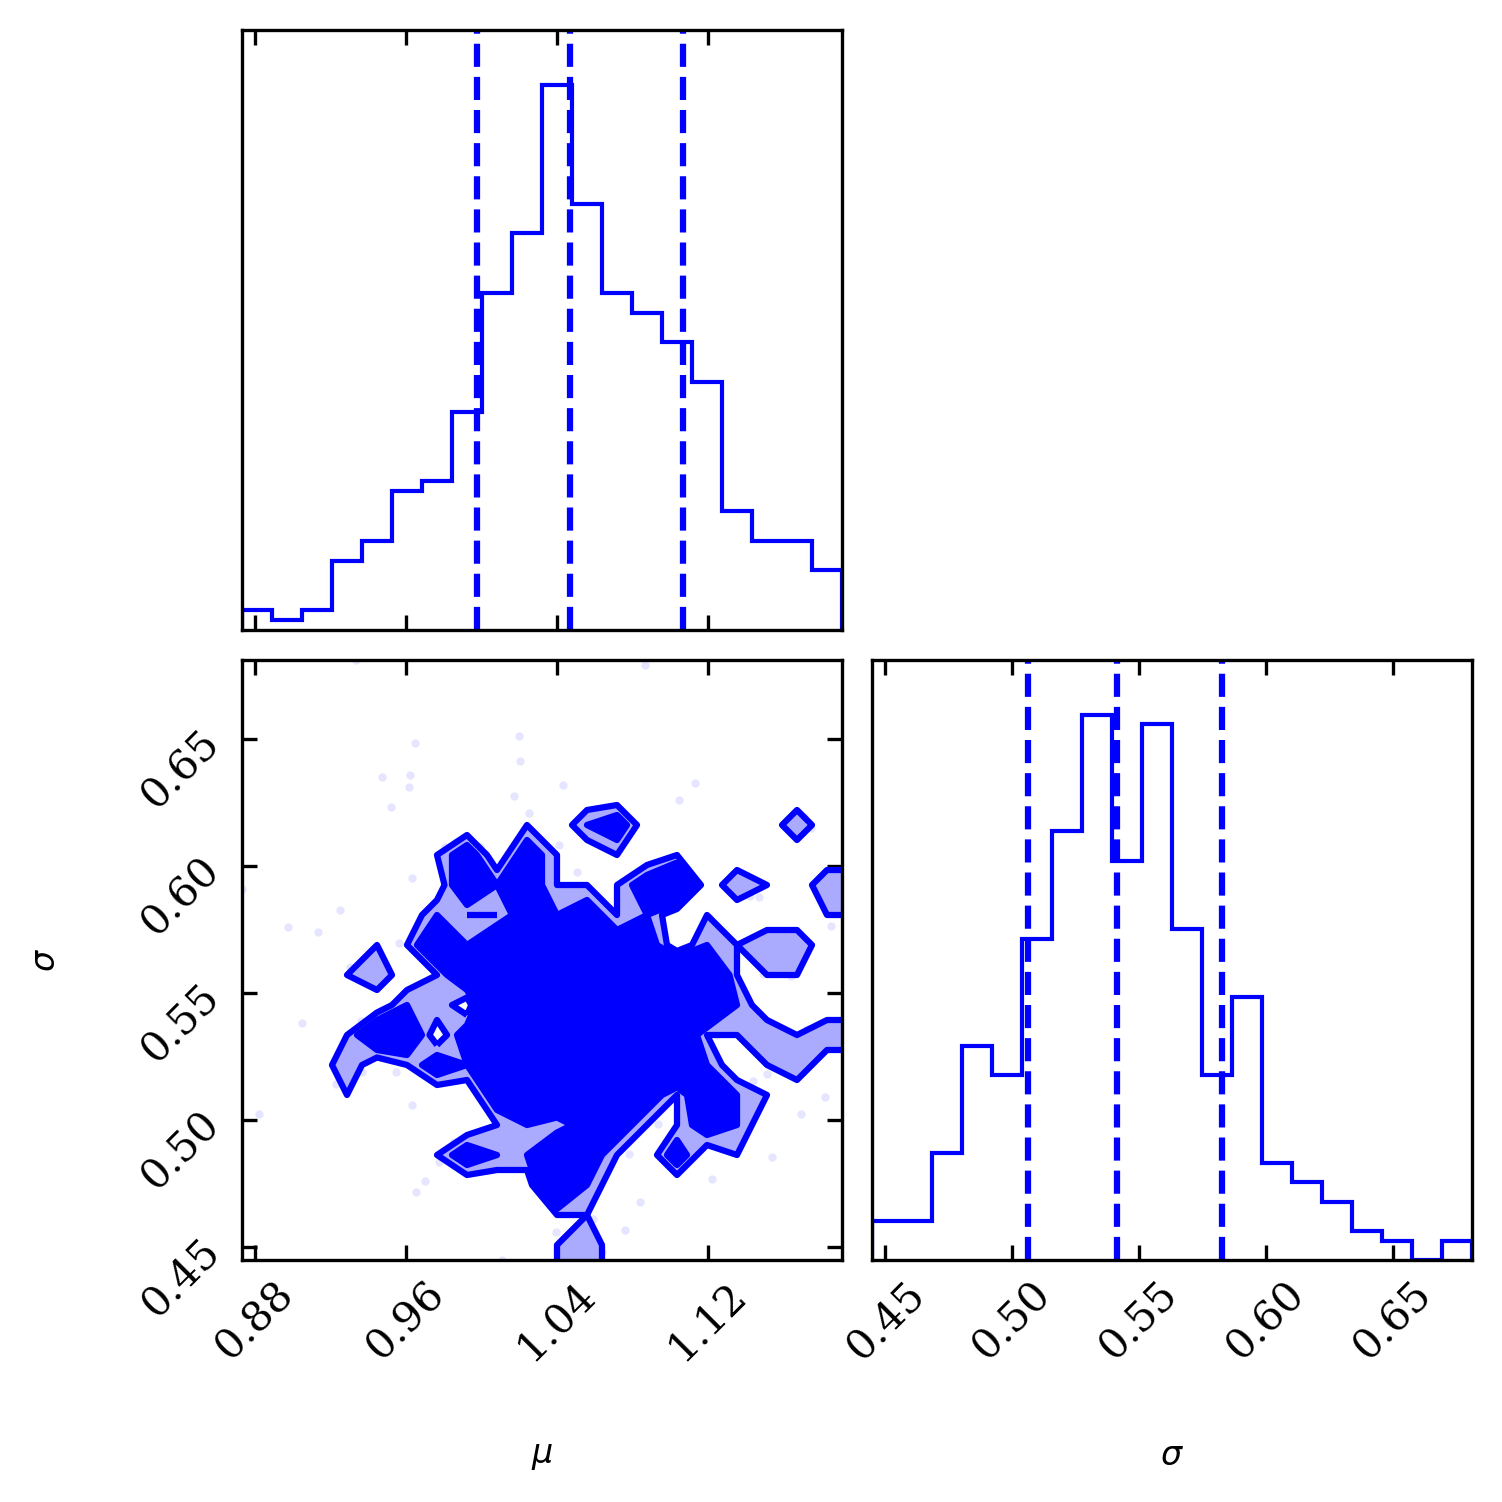

In [79]:
import corner
import numpy as np
import matplotlib.pyplot as plt

# The data
samples = np.vstack((mu_downsampled[burn:], sigma_downsampled[burn:])).T

# Create a corner plot
fig = corner.corner(
    samples,
    labels=["$\mu$", "$\sigma$"],  # Add LaTeX-style labels for your parameters
    levels=(0.68, 0.95),  # Contour levels
    color="b",  # Color of contours
    fill_contours=True,  # Fill the contours with color
    plot_density=True,  # Plot the 2D density of the data
    quantiles=[0.16, 0.5, 0.84],  # Quantiles to display
    title_kwargs={"fontsize": 16, "pad": 20},  # Title font size and padding
)

# Customize axis labels and titles
for ax in fig.get_axes():
    ax.tick_params(axis="both", labelsize=10)
    ax.title.set_fontsize(12)

# Save or display the plot
plt.savefig("corner_plot.png", dpi=300)  # Save as an image file
plt.show()  # Display the plot


In [80]:
# import acor
# acor.acor(chain[:,0]) 
# # the first element of the tuple is the length between independent samples.
# # thin by the nearest integer.

## Gibbs Sampling <a class="anchor" id="one"></a>

**Gibbs sampling** is an MCMC method that avoids acceptance-rejection techniques. Instead, one sweeps through each parameter (or block of parameters) to draw from their ***conditional probability distributions***, with all other parameters fixed to their current values. 

After sampling for a sufficiently large number of Gibbs steps, the principles of MCMC guarantee that **this process of sequential conditional probability drawing will converge to the joint posterior distribution of the overall model parameter space**. A standard Gibbs algorithm is shown below.

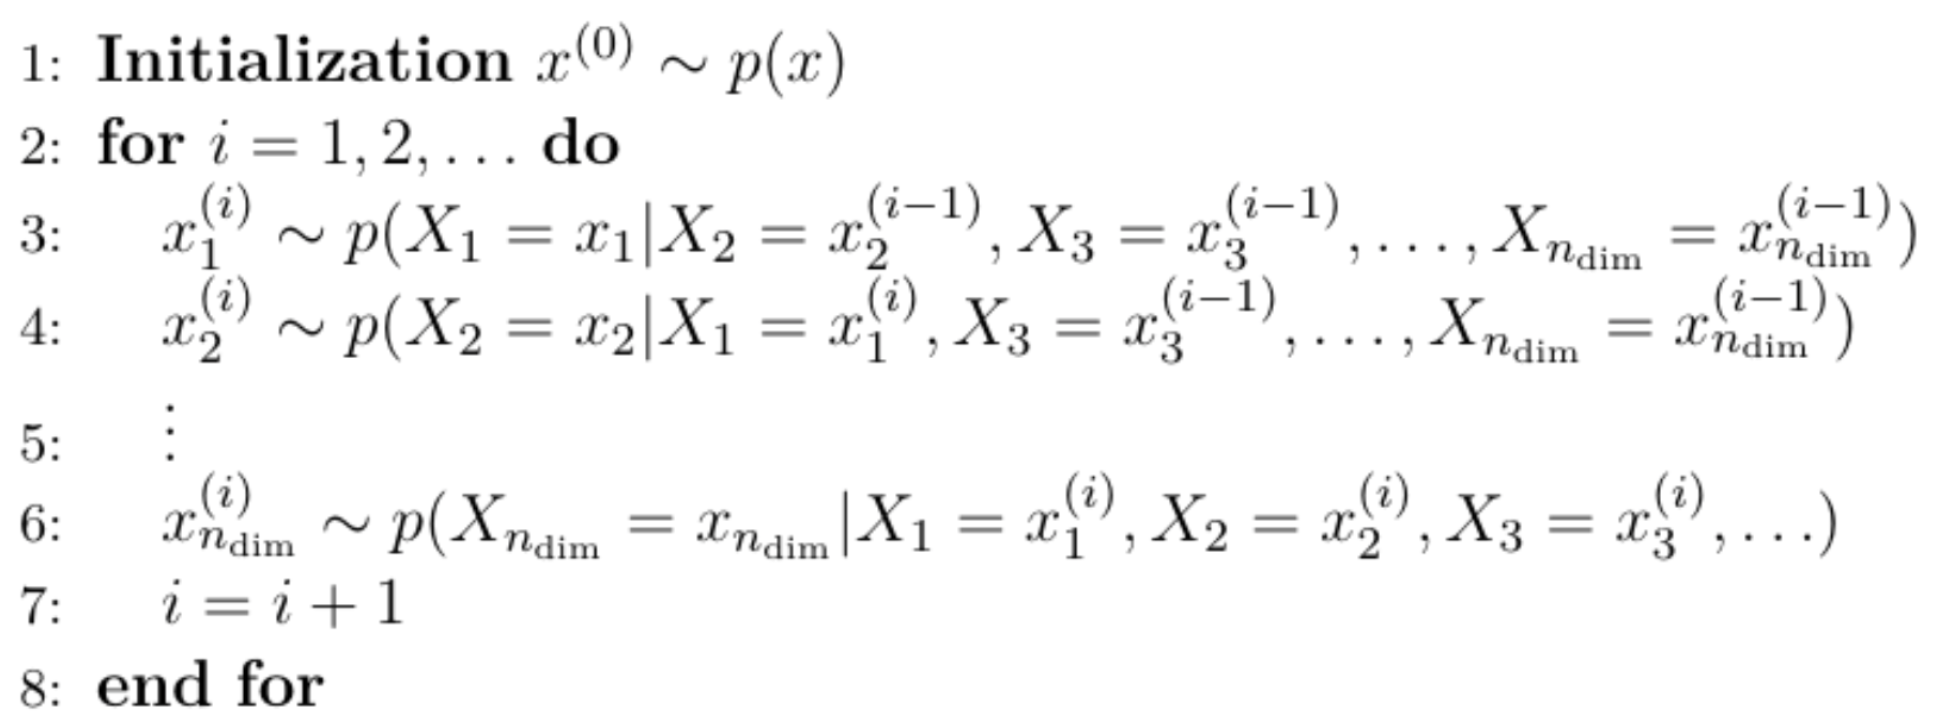

To break this algorithm up into words, we

- We initialize the sampler at some random point in parameter space.


- Fix all parameters except the first one. Draw a random value from the conditional posterior probability distribution of this first parameter **given** the fixed values of all other parameters.


- Fix all parameters except the second one. Draw a random value from the conditional posterior probability distribution of this second parameter **given** the fixed values of all other parameters **and the updated value of the first parameter**.


- *et cetera* for all parameters.


- Repeat for many Gibbs steps.



### Benefits of Gibbs Sampling <a class="anchor" id="onea"></a>

- By drawing directly from the posterior conditionals, the **auto-correlation length can be exceptionally small**, with **minimal burn-in**. 
- **It's also fast**; sequential draws directly from the parameter posterior conditionals means that we are not rejecting any points. 

### Drawbacks of Gibbs Sampling <a class="anchor" id="oneb"></a>

- You need to know the form of the conditional probability distributions for each parameter (or parameter blocks), and how to draw samples from it. 
- This can be a non-trivial problem, so typically a lot of effort is placed in manipulating the form of the posterior to find a conditional that is a standard probability distribution. This is where **conjugate priors** become really handy. 

### Conjugate Priors (Again) <a class="anchor" id="onec"></a>

> *These are parameter priors for which the the posterior lies in the same family of distributions as the prior.* 

***EXAMPLE***

- Imagine we have a Gaussian likelihood function with mean $\mu$ and variance $\sigma^2$ parameters. 
- The conjugate prior on $\mu$ when $\sigma^2$ is known (as is assumed in Gibbs when sweeping through each parameter) is a Gaussian distribution.
- Thus the conditional posterior distribution on $\mu$ is simply a Gaussian. 
- Similarly, the conjugate prior on $\sigma^2$ when $\mu$ is known is an inverse gamma distribution.
- Thus the conditional posterior distribution on $\sigma^2$ is an inverse gamma distribution.

#### Gibbs Approach

Code for this example is adapted from https://wiseodd.github.io/techblog/2015/10/09/gibbs-sampling/, https://bookdown.org/rdpeng/advstatcomp/gibbs-sampler.html, and https://www.wikiwand.com/en/Conjugate_prior. 

---

To make the Gibbs approach work, we need the conjugate priors for the mean and variance of a Gaussian likelihood. These are a Gaussian for the mean, and an inverse Gamma for the variance. We'll make these broad so that our posterior constraints are data-dominated.

$$ p(\mu) = \mathcal{N}(\mu_0,\sigma_0) = \frac{1}{\sqrt{2\pi\sigma_0^2}}\exp\left(\frac{-(\mu-\mu_0)^2}{2\sigma_0^2} \right)$$

where $\mu_0,\sigma_0$ are the location and scale parameters of the Gaussian prior on $\mu$, and 

$$ p(\sigma^2) = \mathrm{IG}(\alpha,\beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} (1/\sigma^2)^{\alpha+1}\exp(-\beta/\sigma^2)$$

where $\alpha,\beta$ are parameters defining the shape of the inverse Gamma prior on $\sigma^2$.

It is algebraically tedious and relatively straightforward to multiply the Gaussian likelihood of the data with each of these priors in turn to work out the posterior conditional distributions on $\mu$ and $\sigma^2$. These turn out to be

$$ p(\mu|\{x_i\}) = \mathcal{N}(\mu_*,\sigma_*)$$

where 

$$\mu_* = \left( \frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right)^{-1} \left(\frac{\mu_0}{\sigma_0^2} + \frac{\sum^n_{i=1}x_i}{\sigma^2} \right)$$

$$\sigma^2_* = \left( \frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right)^{-1} $$

and 

$$ p(\sigma^2|\{x_i\}) = \mathrm{IG}(\alpha_*,\beta_*)$$

where 

$$ \alpha_* = \alpha + n/2$$

$$ \beta_* = \beta + \frac{\sum^n_{i=1}(x_i-\mu)^2}{2}$$

In [81]:
# conditional of \mu
def p_mu_given_sigma2(sigma2, x, mu0, sigma0):
    sigma_star2 = 1.0 / ( (1.0 / sigma0**2.) + (x.shape[0] / sigma2) )
    mu_star = sigma_star2 * ((mu0/sigma0**2.) + (np.sum(x)/sigma2))
    return np.random.normal(loc=mu_star, scale=np.sqrt(sigma_star2))

# conditional of \sigma^2
def p_sigma2_given_mu(mu, x, alpha, beta):
    alpha_star = alpha + x.shape[0]/2.
    beta_star = beta + np.sum((x-mu)**2.)/2.
    return stats.invgamma.rvs(a=alpha_star, scale=beta_star)


def gibbs_sampling(data, mu_initial, sigma2_initial,
                   mu0, sigma0, alpha, beta, iter=2000):
    samples = np.zeros((iter, 2))
    samples[0,:] = [mu_initial, sigma2_initial]

    for ii in range(1,iter):
        # sequential sampling of posterior conditionals
        ### mu first
        mu_new = p_mu_given_sigma2(samples[ii-1,1], data, mu0, sigma0)
        samples[ii,0] = mu_new
        ### then sigma2
        sigma2_new = p_sigma2_given_mu(samples[ii,0], data, alpha, beta)
        samples[ii,1] = sigma2_new

    return samples

In [82]:
# starting point
mu_initial = 0.2
sigma2_initial = 0.6

# priors
mu0 = 1.0
sigma0 = 0.9
alpha = 1.0
beta = 1.0

## SAMPLE!
def run_gibbs():
    samples = gibbs_sampling(data, mu_initial, sigma2_initial, 
                             mu0, sigma0, alpha, beta)
    return samples

In [83]:
samples = run_gibbs()

In [86]:
# thin = int(np.round_(acor.acor(samples[:,0])[0]))
# print('Taking every n = ' + str(thin) + ' samples based on ac length.')
# print('Burning first n = ' + str(500) + ' samples.')

# plt.plot(samples[500::thin,0]);
# plt.plot(samples[500::thin,1]);
# plt.ylabel('Samples')
# plt.xlabel('Iterations')
# # injected values
# plt.hlines(1.0, 0.0, 1500, color='k', lw=2, ls='dashed');
# plt.hlines(0.5, 0.0, 1500, color='k', lw=2, ls='dashed');

Taking every n = 1 samples based on ac length.
Burning first n = 500 samples.


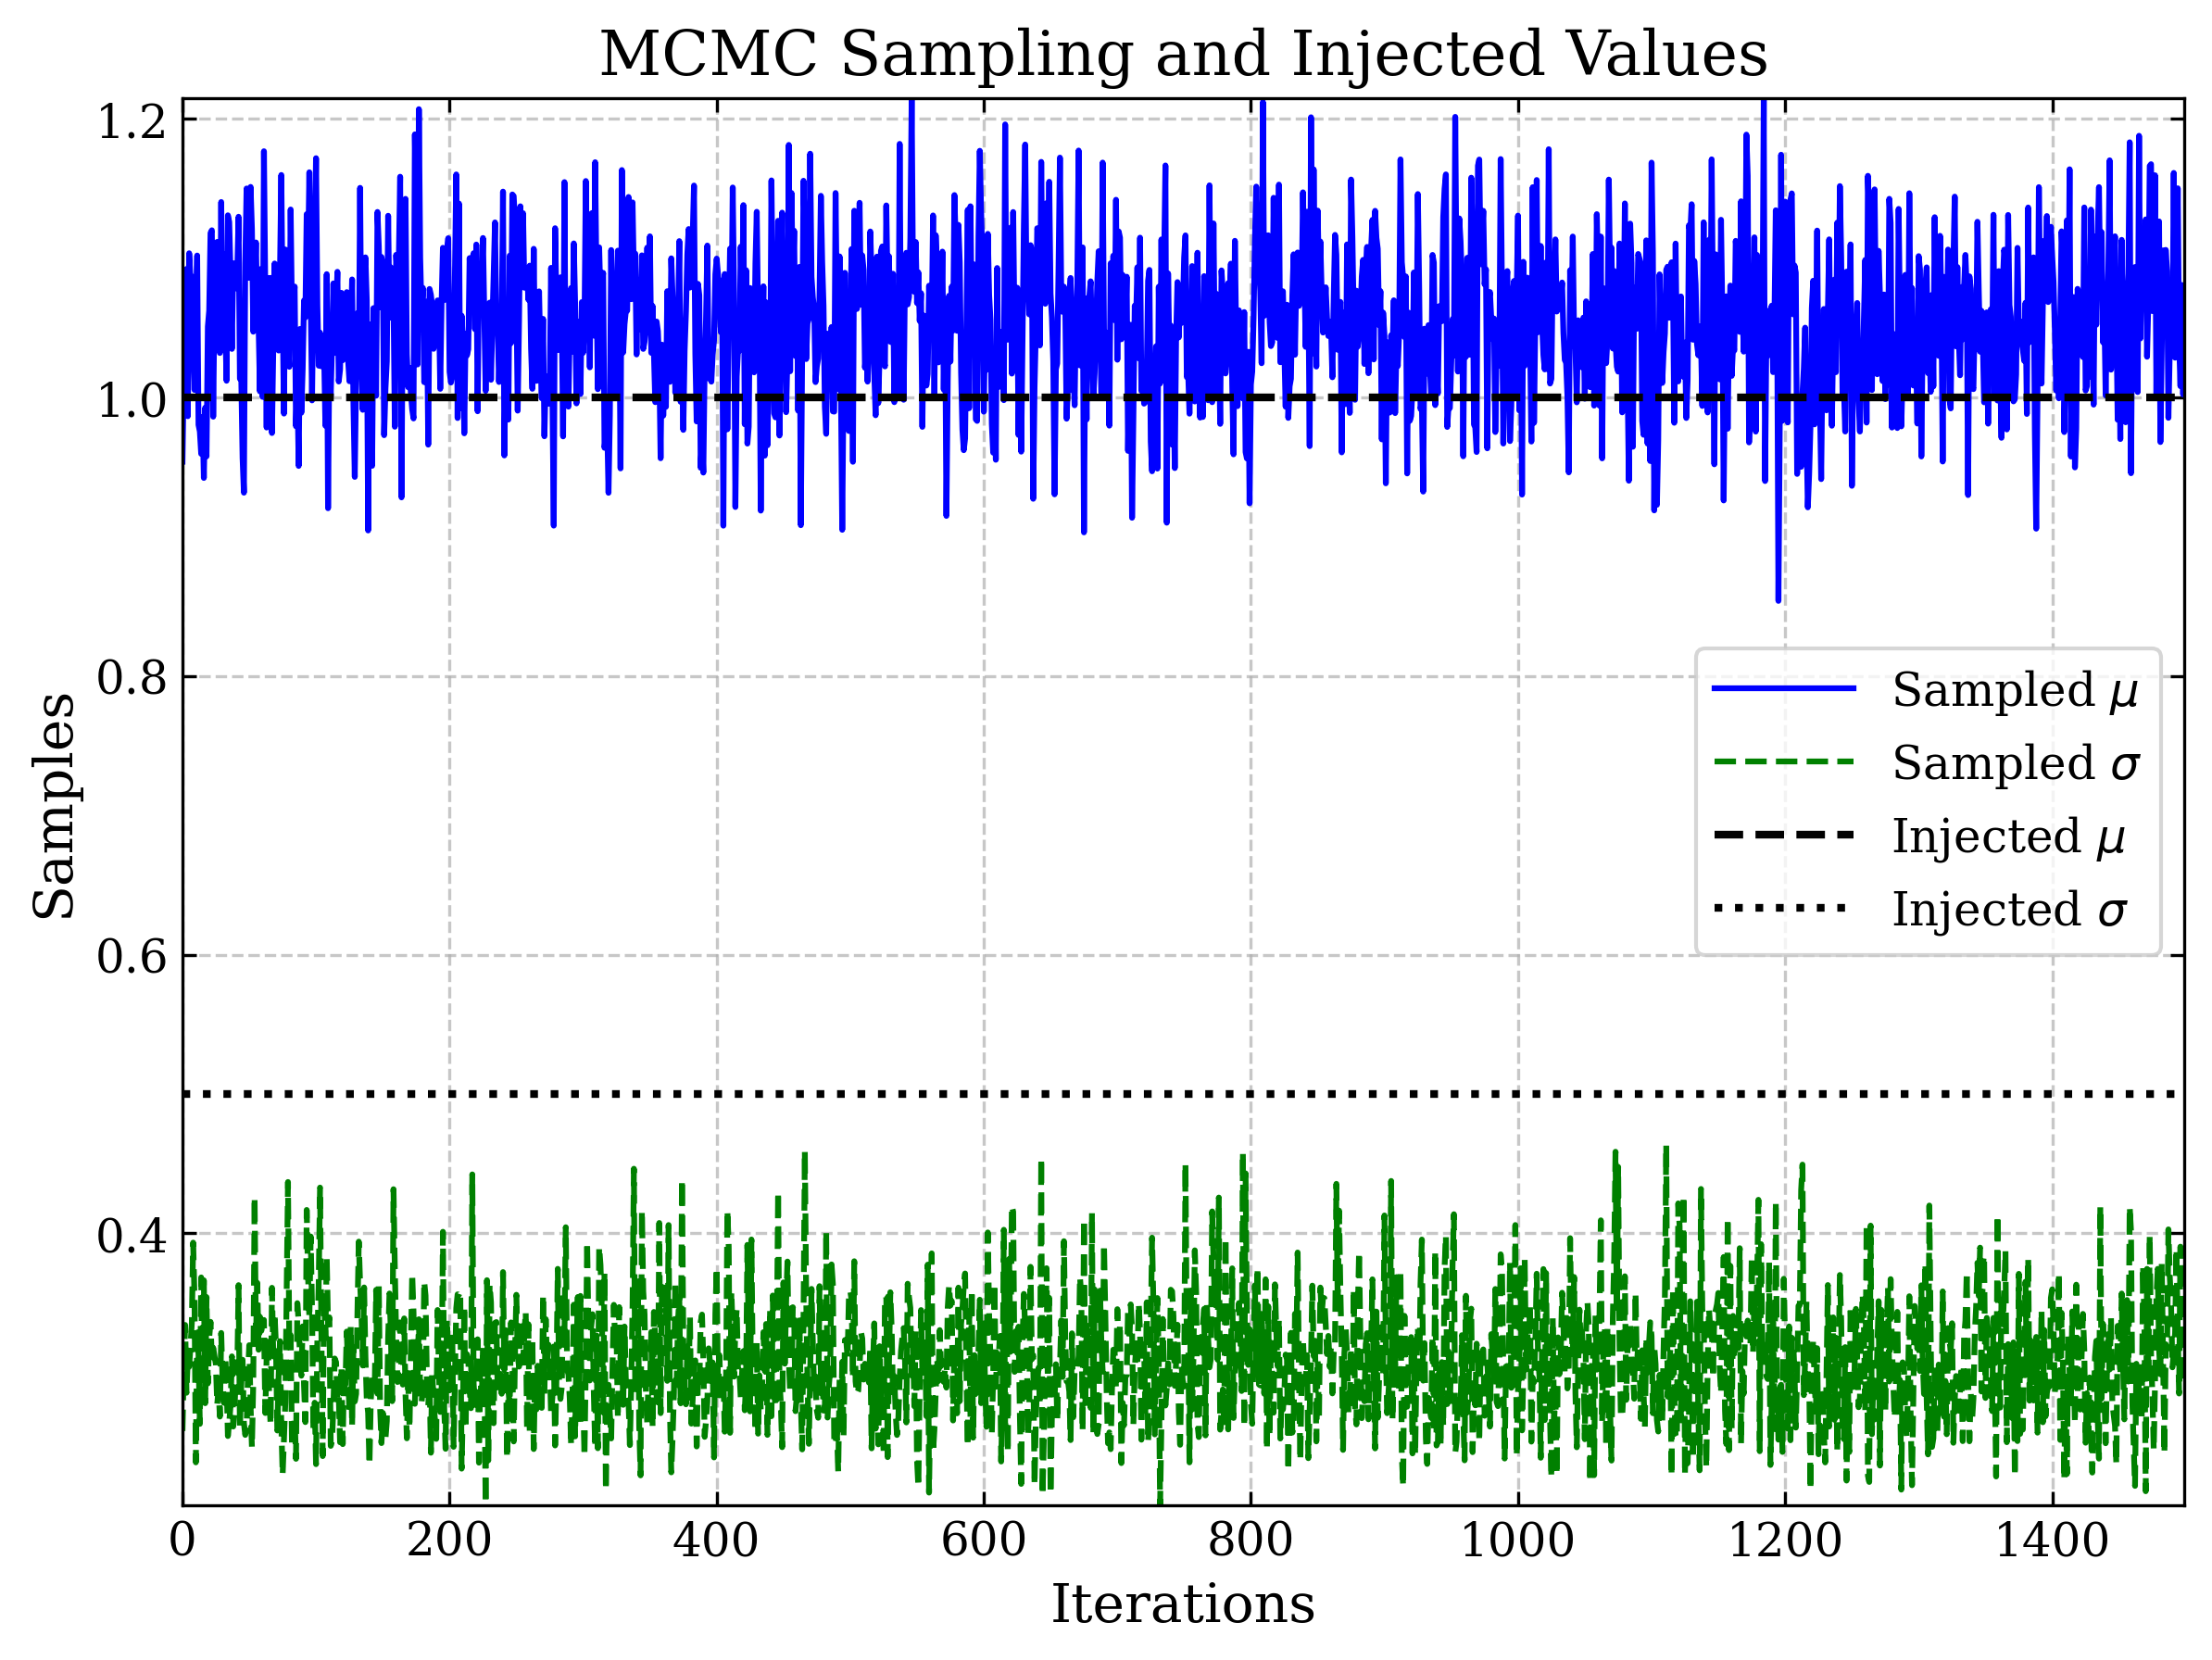

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the thinning factor
thin = int(np.round_(acor.acor(samples[:, 0])[0]))
print('Taking every n = ' + str(thin) + ' samples based on ac length.')
print('Burning first n = ' + str(500) + ' samples.')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the sampled values with customized line styles and labels
ax.plot(samples[500::thin, 0], label='Sampled $\mu$', color='b', linestyle='-')
ax.plot(samples[500::thin, 1], label='Sampled $\sigma$', color='g', linestyle='--')

# Add horizontal lines for injected values
ax.axhline(1.0, color='k', linestyle='--', linewidth=2, label='Injected $\mu$')
ax.axhline(0.5, color='k', linestyle=':', linewidth=2, label='Injected $\sigma$')

# Set axis labels and title
ax.set_ylabel('Samples', fontsize=14)
ax.set_xlabel('Iterations', fontsize=14)
ax.set_title('MCMC Sampling and Injected Values', fontsize=16)

# Customize legend
ax.legend(loc='best', fontsize=12)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Customize tick labels and font size
ax.tick_params(axis='both', labelsize=12)

# Show the plot
plt.tight_layout()
plt.show()


**Gibbs sampling is awesome...provided that you can work out the analytic conditional posteriors as standard distribution forms.** 

But even if you can't, all is not lost. You can get inventive by embedding a short Metropolis-Hastings block within the Gibbs algorithm. For example, if there are parameters for which you can not directly draw from the conditional, then your Gibbs step for that parameter could be a short Metropolis-Hastings MCMC run. 

The goal is to run this sufficiently long enough that you have drawn a single quasi-independent random sample from the parameter posterior conditional distribution, with all other parameters fixed. You can then proceed through the remainder of your Gibbs steps as normal. 